In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Simulace trajektorie

Pro vytvoření simulace jsme použili Gamma a Exponenciální rozdělení z knihovny numpy. 

V cyklu generujeme vzorky z exponenciálního rozdělení jakožto přírůstky dob příchodu zákazníka a k nim vzorky z Gamma rozdělení, které odpovídají době odbavení (a tedy i odchodu ze systému).

In [2]:
class Queueing:
    def __init__(self, p, alpha, _lambda):
        self.p = p
        self.alpha = alpha
        self._lambda = _lambda

    def _get_trajectory(self, start, end):
        '''
        Creates a single trajectory realisation of the system.
        '''
        events = [(0,0)]    
        while start < end:
            arrival = np.random.exponential(1/self._lambda)

            if start + arrival  > end:
                break

            departure = np.random.gamma(shape=self.p, scale=1/self.alpha)
            start += arrival    

            events.append((start, 1))
            events.append((start + departure, -1))

        events.sort(key=lambda x: x[0])

        process = np.array(events).T
        process[1] = process[1].cumsum()
        return process
    
    def get_trajectories(self, start, end, size=1):
        return [self._get_trajectory(start, end) for i in range(size)]
            

In [3]:
Q = Queueing(p=2, alpha=4, _lambda=10)

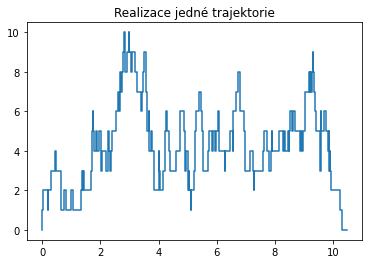

In [4]:
process = Q.get_trajectories(0, 10)[0]
plt.figure()
plt.step(process[0], process[1]);
plt.title('Realizace jedné trajektorie');


### Simulace 500 trajektorí

V této části využijeme výše zmíněnou implementaci systému k vygenerování 500 trajektorií, ze kterých následně vyextrahujeme vždy stý prvek. 

In [5]:
trajectories = Q.get_trajectories(0, 100, size=500)

In [6]:
df = pd.DataFrame({'value': np.array([ counts[time < 100][-1] for time, counts in trajectories])}) # vygenerování trajektorií a extrakce X_100
df = df.value_counts().sort_index().rename('occurences').to_frame().reset_index()
df['frequencies'] = df['occurences'] / df['occurences'].sum() # spočítání frekvencí

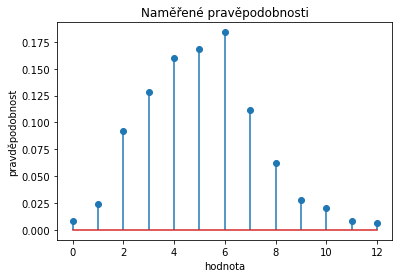

In [7]:
plt.plot()
plt.title('Naměřené pravěpodobnosti')
plt.xlabel('hodnota')
plt.ylabel('pravděpodobnost')
plt.stem(df['value'], df['frequencies']);

### Rozdělení pro $t \rightarrow \inf$


Pro $t \rightarrow \inf$ má systém Poissonovo rozdělení s intenzitou $\frac{\lambda}{\mu}$.

$\mu$ je neznámý parametr, který odpovídá převrácené střední hodnotě doby obsluhy, tj. 
$$\frac{1}{\mu} = {E[\textit{Gamma}(a=4,p=2)]}  $$
$$\frac{1}{\mu} = \frac{p}{a} = \frac{1}{2}$$
$$\mu = 2$$


Intenzita pro $t \rightarrow \inf  $ má rozdělení $ \textit{Poisson}(\frac{10}{2})=  \textit{Poisson}(5)$ 


In [8]:
df['expected_frequencies'] = df['value'].apply(lambda x: scipy.stats.poisson.pmf(x, 5))
df['expected_occurences'] = df['expected_frequencies'] * 500

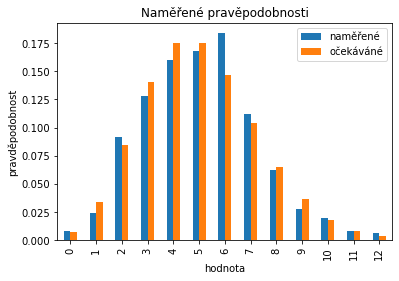

In [12]:
fig, ax = plt.subplots()
plt.title('Naměřené pravěpodobnosti')
plt.xlabel('hodnota')
plt.ylabel('pravděpodobnost')

df[['frequencies', 'expected_frequencies']].plot(kind='bar', ax=ax)
ax.legend(['naměřené', 'očekáváné']);


#### Test shody rozdělení

K testu, zda-li odpovídá rozdělení tomu teoretickému použijeme chí-kvadrát test (test dobré shody) se známým parametrem Poissonova rozdělení.

In [10]:
def chi2(observed, expected, ddof=0, alpha=0.05):
    '''
    observed: Observed frequencies of random each category e. g. [7, 8, 9, 15]
    expected: Expected frequencies of random each category (n*p_c) e. g. [n*p_i for i in range(num_classes))]
        n = number of samples
        p_i = probability of ith class
        
    ddof: (difference degrees of freedom) for N-1 dof use 1
    
    '''
    assert ddof < len(observed)

    # Testování kritéria
    if sum(observed)/len(observed) < 5:
        print("!!!!!!! Kritérium nesplněno !!!!!!!")
    
    T_dist = 'Chí-kvadrát'
    
    crit_val = scipy.stats.chi2.isf(alpha,  len(observed)-ddof)
    
    statistic, p_value = scipy.stats.chisquare(observed, expected, ddof=ddof)
    
    print('Test dobré shody (chí-kvadrát)')
    print('='* 40)
    print("Na hladině " + str((1-alpha)*100) + "% testujeme hypotézu")
    print("H0: Rozdělení jsou stejná. Oproti alternativě")
    print("HA: Rozdělení nejsou stejná.")
            
    print(f'Testová statistika má rozdělení {T_dist} s {len(observed) - 1 - ddof} stupni volnosti')
    print()
    print(f'Kritická hodnota testové statistiky:\t\t', crit_val)
    print(f'Hodnota testové statistiky: \t\t\t', statistic)

    print(f'p-hodnota: \t\t\t\t\t', p_value)

    
    if p_value < alpha:
        print("Zamítáme H_0 ve prospěch alternativy H_A")
        print(f"p_value {p_value} < alpha {alpha}")
        
    else:
        print("Nezamítáme H_0 ve prospěch alternativy H_A")
        print(f"p_value {p_value} > alpha {alpha}")


In [11]:
chi2(df['occurences'], df['expected_occurences'], alpha=0.05)

Test dobré shody (chí-kvadrát)
Na hladině 95.0% testujeme hypotézu
H0: Rozdělení jsou stejná. Oproti alternativě
HA: Rozdělení nejsou stejná.
Testová statistika má rozdělení Chí-kvadrát s 12 stupni volnosti

Kritická hodnota testové statistiky:		 22.362032494826945
Hodnota testové statistiky: 			 10.492163973287122
p-hodnota: 					 0.5728662219991625
Nezamítáme H_0 ve prospěch alternativy H_A
p_value 0.5728662219991625 > alpha 0.05


## Diskuze

V tomto domácím úkolu se nám podařilo naimplementovat simulaci obslužného systému. V další části jsme simulovali 500 trajektorií a pro náhodnou veličinu $N_{100}$ jsme naměřili empirické rozdělení dat.

Toto empirické rozdělení by podle teorie mělo odpovídat Poissonovskému procesu, v našem případě s intenzitou 5. Po vykonání testu dobré shody nezamítáme nulovou hypotézu, že se jedná o stejná rozdělení.